# To-do
- [x] Implement baseline PINN without the bathymetric profile beta and forcing
- [debugging in progress] Incorporate beta and forcing
- [ ] Validate model on some explicit solutions 
- [ ] Transfer model and generate approximate solution for given forcing 
- [ ] Generate plots
- [ ] Speed up training (optimize code, add batches)


# Additional possible implementations 
- [ ] Incorporate hyperparameter tuning with Optuna
- [ ] Add interpretability (implement Fourier approximator?)
- [ ] Add ensemble methods to boost performance
- [ ] Vectorize 

In [212]:
################################################################################
# SETUP
################################################################################

# Convenience and saving flags
ABRIDGED_RUN = True # Set to True to train and validate on less epochs, for quick funcitonality tests etc
SAVE_AFTER_TRAINING = True # Save the model when you are done
SAVE_CHECKPOINTS = True # Save the model after every epoch
REPORT_TRAINING_LOSS_PER_EPOCH = True # Track the training loss each epoch, and write it to a file after training
REPORT_VALIDATION_LOSS_PER_EPOCH = True # Lets us make a nice learning curve after training

# Training hyperparameters
NUM_EPOCHS = 25000 # Number of epochs to train our network
NUM_BDD = 1000
NUM_COLLOCATION = 10000
NUM_X = 1000
NUM_Y = 1000
NN_WIDTH = 128

#For quick testing
if ABRIDGED_RUN == True:
    NUM_EPOCHS = 1001
    NUM_BDD = 100 
    NUM_COLLOCATION = 100
    NUM_X = 100
    NUM_Y = 100
    NN_WIDTH = 16


LEARNING_RATE = 1e-5 # Learning rate for our optimizer
DROPOUT = 0.05

# Directories
CHECKPOINT_DIR = "checkpoints/" # Checkpoints, models, and training data will be saved here
MODEL_NAME = None

#PDE parameters 
A = 1 
G = 1
kappa = 1

In [213]:
################################################################################
# IMPORTS
################################################################################

print("Importing modules")

# Basic imports
import pandas as pd
import numpy as np
np.random.seed(1234)
import time
import scipy.io
from scipy.stats import qmc
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split
from pathlib import Path

# Torch imports
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
torch.set_default_dtype(torch.float)
torch.manual_seed(1234)
print("Import complete")


device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"{device} enabled")

Importing modules
Import complete
mps enabled


## Stationary SWE 

We want to approximate solutions $u: \mathbb{T}^2 \to \mathbb{R}^2, \eta: \mathbb{T}^2 \to \mathbb{R}$ satisfying the PDE (with $\beta:  \mathbb{T}^2 \to \mathbb{R}$ fixed)
$$ \begin{equation}
    \begin{cases}
        \nabla\cdot((1+\beta+\eta)\pmb{u})=0, \; \text{in} \; \mathbb{T}^2\\
        \nabla\cdot( (1+\beta+\eta)\pmb{u}\otimes\pmb{u})+A\pmb{u}-\nabla\cdot((1+\beta+\eta)\mathbb{S}\pmb{u})+(1+\beta+\eta)(G-\Delta)\nabla\eta= F = \kappa\Phi, \; \text{in} \; \mathbb{T}^2\\
        \Phi=\phi(\cdot,\eta)+\nabla((1+\beta+\eta)\psi(\cdot,\eta))+\tau(\cdot,\eta)\nabla\eta.
    \end{cases},
\end{equation} $$
where $\mathbb{R} \ni A,G > 0, \; \kappa \in [0,\infty), \phi: \mathbb{T}^2 \times \mathbb{R} \to \mathbb{R}, \; \psi: \mathbb{T}^2 \times \mathbb{R} \to \mathbb{R}, \tau: \mathbb{T}^2 \times \mathbb{R} \to \mathbb{R}^{2 \times 2}_{\text{sym}}$ and $\mathbb{S}v = \nabla v+ (\nabla v)^{T} +2(\nabla \cdot v)I$. For simplifiy we set $A = G = \kappa = 1$. 

The second equation can be simplfiied to 

$$  (\nabla \cdot u^T) (1+\beta+\eta) u + u - \nabla\cdot((1+\beta+\eta)\mathbb{S}\pmb{u})+(1+\beta+\eta)(G-\Delta)\nabla\eta= F, \; \text{in} \; \mathbb{T}^2$$

The system in component form is (implemented this version for the sake of time, vectorizing required some debugging)

$$ \begin{equation}
    \begin{cases}
        (1+\beta + \eta)(\partial_1 u_1 + \partial_2 u_2) + \partial_1 u (\partial_1 \beta + \partial_1 \eta) + \partial_2 u (\partial_2 \beta + \partial_2 \eta) = 0, \; \text{in} \; \mathbb{T}^2\\
        (\partial_1 u_2 + \partial_2 u_1)(1+\beta + \eta)u_1 + u_1- \partial_1(\beta + \eta)(4 \partial_1 u_1 + 2 \partial_2 u_2) - \partial_2 (\beta+\eta) (\partial_1 u_2 + \partial_2 u_1) - (1+\beta+\eta)(\partial_2^2 u_1 + 4 \partial_1^2 u_1 + 3 \partial_1 \partial_2 u_2)+(1+\beta+\eta)(\partial_1 \eta - \partial_1^3 \eta - \partial_2^2 \partial_1 \eta)= F_1, \; \text{in} \; \mathbb{T}^2\\
        (\partial_1 u_2 + \partial_2 u_1)(1+\beta + \eta)u_2 +u_2 -\partial_1(\beta + \eta)(\partial_1 u_2 + \partial_2 u_1) - \partial_2 (\beta+\eta) (4 \partial_2 u_2 + 2 \partial_1 u_1)  - (1+\beta+\eta)(\partial_1^2 u_2 + 4 \partial_2^2 u_2 + 3 \partial_1 \partial_2 u_1)+(1+\beta+\eta)(\partial_2 \eta - \partial_1^2 \partial_2 \eta - \partial_2^3 \eta)= F_2, \; \text{in} \; \mathbb{T}^2\\
    \end{cases},
\end{equation} $$

# Some explciit solutions for verification

Test case 1:
u = ... 
eta = ... 
f = ...

Test case 2
u = ... 
eta = ... 
f = ...

Test case 3
u = ... 
eta = ... 
f = ...

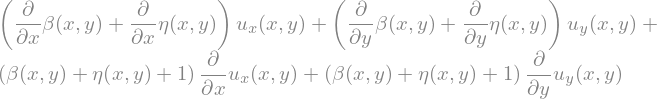

In [214]:
#Symbolic verification for the component form, modify and use if necessary
import sympy as sp
from sympy import *
from sympy.vector import divergence
init_printing() 

x, y = sp.symbols('x y')
u_x, u_y = sp.symbols('u_x u_y', cls=sp.Function)
beta, eta = sp.symbols('beta eta', cls=sp.Function)

u_x = u_x(x, y)
u_y = u_y(x, y)
beta = beta(x, y)
eta = eta(x, y)

f = 1 + beta + eta
u = sp.Matrix([u_x, u_y])

def sympy_divergence(f, x):
    return sum(f_i.diff(x_i) for f_i, x_i in zip(f, x))

simplify(sympy_divergence(f*u, [x,y]))

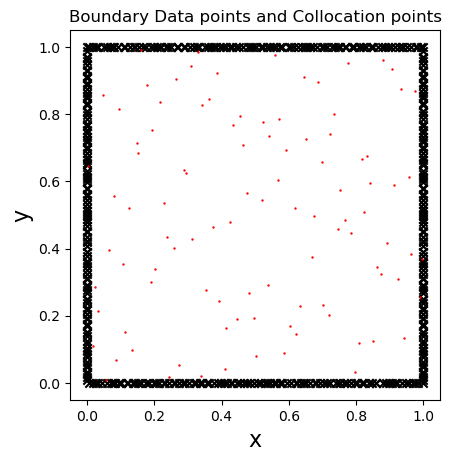

In [215]:
################################################################################
# DOMAIN INITIALIZATION
################################################################################

x_min = 0
x_max = 1
y_min = 0
y_max = 1

total_points_x = NUM_X
total_points_y = NUM_Y

N_boundary = 4 # number of boundaries
N_u_boundary = NUM_BDD # number of points on each boundary
N_u = N_boundary * N_u_boundary
N_f = NUM_COLLOCATION # number of collocation points

#Boundary condition weights in loss function 
w_bc_tb = 1
w_bc_lr = 1

engine = qmc.LatinHypercube(d=1)

boundary_top = engine.random(n = N_u_boundary)
boundary_lr = engine.random(n = N_u_boundary)
boundary_bot = engine.random(n = N_u_boundary)

data = np.zeros([N_boundary, N_u_boundary, 2])

data[0, :, 0] = boundary_top[:, 0]
data[1, :, 1] = boundary_lr[:, 0]
data[2, :, 1] = boundary_lr[:, 0]
data[3, :, 0] = boundary_bot[:, 0]

data[0, :, 1] = np.ones(N_u_boundary) # y = 1
data[1, :, 0] = np.zeros(N_u_boundary) # x = 0
data[2, :, 0] = np.ones(N_u_boundary) # x = 1
data[3, :, 1] = np.zeros(N_u_boundary) # y = 0

data = data.reshape(-1, 2)
x_d, y_d = data[:, 0:1], data[:, 1:2]

engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n = N_f)

x_f, y_f = colloc[:, 0:1], colloc[:, 1:2]

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=2., marker=".", c="r", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
#plt.show()


In [216]:
x = torch.linspace(x_min, x_max, total_points_x)
y = torch.linspace(y_min, y_max, total_points_y)

X, Y = torch.meshgrid(x, y)

#(x,y) coordinates for validaiton 
xy_test = torch.hstack((X.transpose(1, 0).flatten()[:, None], Y.transpose(1, 0).flatten()[:, None]))
xy_test = xy_test.float().to(device)


train_bd_top = torch.tensor(boundary_top).float().to(device)
train_bd_lr = torch.tensor(boundary_lr).float().to(device)
train_bd_bot = torch.tensor(boundary_bot).float().to(device)

x_train_colloc = torch.tensor(x_f).float().to(device)
y_train_colloc = torch.tensor(y_f).float().to(device)

In [217]:
class PINN(nn.Module):

    def __init__(self, beta, forcing):
        super().__init__()
    
        self.beta = beta
    
        self.f = forcing
        
        self.loss_function = nn.MSELoss(reduction='mean')
        
        #Architecture for approxiamting vector field u
        self.u =  nn.Sequential(
            nn.Linear(2, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            #Adding dropout layers to curb overfitting
            nn.Dropout(p=DROPOUT),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Dropout(p=DROPOUT),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Dropout(p=DROPOUT),
            nn.Linear(NN_WIDTH, 2) 
            )
        
        #Architecture for approxiamting scalar field eta
        self.eta = nn.Sequential(
            nn.Linear(2, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Dropout(p=DROPOUT),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Dropout(p=DROPOUT),
            nn.Linear(NN_WIDTH, NN_WIDTH),
            nn.Tanh(),
            nn.Dropout(p=DROPOUT),
            nn.Linear(NN_WIDTH, 1) 
            )
        
        if ABRIDGED_RUN:
            self.u =  nn.Sequential(
                nn.Linear(2, NN_WIDTH),
                nn.Tanh(),
                nn.Linear(NN_WIDTH, 2) 
            )
            
            self.eta = nn.Sequential(
                nn.Linear(2, NN_WIDTH),
                nn.Tanh(),
                nn.Linear(NN_WIDTH, 1) 
            )
            
    def forward(self, x, y):
        x = torch.from_numpy(x) if not torch.is_tensor(x) else x
        y = torch.from_numpy(y) if not torch.is_tensor(y) else y
        
        #x = x.unsqueeze(1) if x.ndim == 1 else x
        #y = y.unsqueeze(1) if y.ndim == 1 else y
        
        a = torch.cat((x.float(), y.float()), axis=1)
        
        u = self.u(a)
        eta = self.eta(a)
        return u, eta
    
    # Periodic BC on left/right
    def loss_BC_lr(self, y):
        u_l, eta_l = self.forward(torch.zeros_like(y), y)
        u_r, eta_r = self.forward(torch.ones_like(y), y)
        
        return self.loss_function(u_l, u_r) + self.loss_function(eta_l, eta_r)
    
    # Periodic BC on top/bottom
    def loss_BC_tb(self, x):
        u_top , eta_top = self.forward(x, torch.zeros_like(x))
        u_bottom, eta_bottom = self.forward(x, torch.ones_like(x))
        
        return self.loss_function(u_top, u_bottom) + self.loss_function(eta_top, eta_bottom)
    
    #PDE loss
    def loss_PDE(self, x, y):
        x = x.clone().requires_grad_(True)
        y = y.clone().requires_grad_(True)

        u_pred, eta_pred = self.forward(x, y)
        
        beta = self.beta(x,y)
        f = self.f(x,y)
        
        u1, u2 = u_pred[:, 0:1], u_pred[:, 1:2]
        f1, f2 = f[:, 0:1], f[:, 1:2]

        u1_x = autograd.grad(u1.sum(), x, create_graph=True)[0]
        u1_y = autograd.grad(u1.sum(), y, create_graph=True)[0]
        u2_x = autograd.grad(u2.sum(), x, create_graph=True)[0]
        u2_y = autograd.grad(u2.sum(), y, create_graph=True)[0]
        
        u1_xx = autograd.grad(u1_x.sum(), x, create_graph=True)[0]
        u1_yy = autograd.grad(u1_y.sum(), y, create_graph=True)[0]
        u1_xy = autograd.grad(u1_x.sum(), y, create_graph=True)[0]
        u2_xx = autograd.grad(u2_x.sum(), x, create_graph=True)[0]
        u2_yy = autograd.grad(u2_y.sum(), y, create_graph=True)[0]
        u2_xy = autograd.grad(u2_x.sum(), y, create_graph=True)[0] 
        
        eta_x   = autograd.grad(eta_pred.sum(), x, create_graph=True)[0]
        eta_y   = autograd.grad(eta_pred.sum(), y, create_graph=True)[0]
        eta_xx  = autograd.grad(eta_x.sum()   , x, create_graph=True)[0]
        eta_yy  = autograd.grad(eta_y.sum()   , y, create_graph=True)[0]
        eta_xxx = autograd.grad(eta_xx.sum()  , x, create_graph=True)[0]
        eta_yyy = autograd.grad(eta_yy.sum()  , y, create_graph=True)[0]
        eta_yyx = autograd.grad(eta_yy.sum()  , x, create_graph=True)[0]
        eta_xxy = autograd.grad(eta_xx.sum()  , y, create_graph=True)[0]
    
        beta_x = autograd.grad(beta.sum(), x, create_graph=True)[0]
        beta_y = autograd.grad(beta.sum(), y, create_graph=True)[0]
        
        beta_plus_eta = 1 + beta + eta_pred

        eq1  = beta_plus_eta * (u1_x + u2_y) + u1_x * (beta_x + eta_x) + u1_y * (beta_y + eta_y)
        
        eq2 = (
            (u1_y + u2_x) * beta_plus_eta * u1 
            + A * u1 
            - (beta_x + eta_x) * (4 * u1_xx + 2 * u2_y)
            - (beta_y + eta_y) * (u2_x + u1_y)
            - beta_plus_eta * (u1_yy + 4 * u1_xx + 3 * u2_xy)
            + beta_plus_eta * (G * eta_x - eta_xxx - eta_yyx)
            )
        eq3 = (
            (u1_y + u2_x) * beta_plus_eta * u2 
            + A * u2
            - (beta_x + eta_x) * (u2_x + u1_y)
            - (beta_y + eta_y) * (4 * u2_y + 2 * u1_x)
            - beta_plus_eta * (u2_xx + 4 * u2_yy + 3 * u1_xy)
            + beta_plus_eta * (G * eta_y - eta_yyy - eta_xxy)
            )
        
        loss_eq1 = self.loss_function(eq1, torch.zeros_like(eq1))
        loss_eq2 = self.loss_function(eq2 - f1, torch.zeros_like(eq2))
        loss_eq3 = self.loss_function(eq3 - f2, torch.zeros_like(eq3))
        
        return loss_eq1 + loss_eq2 + loss_eq3
    
    def loss (self, x_top, y_lr, x_PDE, y_PDE):
        return  w_bc_lr * self.loss_BC_lr(y_lr) + w_bc_tb * self.loss_BC_tb(x_top) + self.loss_PDE(x_PDE, y_PDE)

In [218]:
################################################################################
# TRAINING SETUP
################################################################################

def beta(x,y):
    return 0.01* torch.sin(2 * np.pi * x) * torch.sin(2 * np.pi * y)

def forcing(x,y):
    return 0.01* torch.sin(2 * np.pi * x) * torch.sin(2 * np.pi * y)


# Create a saving directory if needed
output_dir = Path(f'{CHECKPOINT_DIR}{MODEL_NAME}')
output_dir.mkdir(parents=True, exist_ok=True)
output_dir = f'{CHECKPOINT_DIR}{MODEL_NAME}'

# Instantiate our model
model = PINN(beta = beta, forcing = forcing).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

summary(model)

Layer (type:depth-idx)                   Param #
PINN                                     --
├─MSELoss: 1-1                           --
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       48
│    └─Tanh: 2-2                         --
│    └─Linear: 2-3                       34
├─Sequential: 1-3                        --
│    └─Linear: 2-4                       48
│    └─Tanh: 2-5                         --
│    └─Linear: 2-6                       17
Total params: 147
Trainable params: 147
Non-trainable params: 0

In [219]:
start_time = time.time()

training_losses = [None]*NUM_EPOCHS
validation_losses = [None]*NUM_EPOCHS

#Turn on the gradient

torch.enable_grad() 

for epoch in tqdm(range(NUM_EPOCHS), leave = False):
    
    optimizer.zero_grad()
    loss = model.loss(train_bd_top, train_bd_lr, x_train_colloc, y_train_colloc)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        # Save checkpoint
        if SAVE_CHECKPOINTS == True:
            torch.save(model.state_dict(), f"{CHECKPOINT_DIR}{MODEL_NAME}/checkpoint_{epoch}.pt")

        # Compute training loss
        if REPORT_TRAINING_LOSS_PER_EPOCH == True:    
            training_losses[epoch] = loss.item()
        
        if REPORT_VALIDATION_LOSS_PER_EPOCH == True:
            model.eval()
            torch.no_grad()
            
            u_pred, eta_pred = model(xy_test[:, 0:1], xy_test[:, 1:2])
            
            u_true = torch.zeros_like(u_pred)
            eta_true = torch.zeros_like(eta_pred)
            
            pred = torch.cat((u_pred, eta_pred), dim=1)
            true = torch.cat((u_true, eta_true), dim=1)
            
            validation_loss = model.loss_function(pred, true)
            validation_losses[epoch] = validation_loss.cpu().item()
            
            model.train()
            torch.enable_grad()
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training loss {loss.item()}, Validation loss {validation_loss.item()}')
        
        losses = pd.DataFrame({"training_losses":training_losses, "validation_losses":validation_losses})
        cols = []
        
        if REPORT_TRAINING_LOSS_PER_EPOCH == True:
            cols += ["training_losses"]
            
        if REPORT_VALIDATION_LOSS_PER_EPOCH == True:
            cols += ["validation_losses"]
            
        if len(cols) > 0:
            losses[cols].to_csv(f'{output_dir}/losses.csv', index = False)
        
end_time = time.time()

print('Finished Training')

print(f'Training time: {end_time - start_time}s')

  0%|          | 0/1001 [00:00<?, ?it/s]/opt/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 0])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: [srcBuf length] > 0 INTERNAL ASSERT FAILED at "/Users/runner/work/_temp/anaconda/conda-bld/pytorch_1720538195853/work/aten/src/ATen/native/mps/OperationUtils.mm":387, please report a bug to PyTorch. Placeholder tensor is empty!

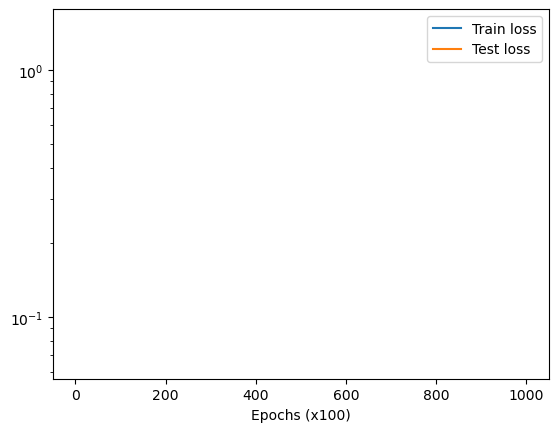

In [203]:
plt.semilogy(training_losses, label='Train loss')
plt.semilogy(validation_losses, label='Test loss')
plt.xlabel('Epochs (x100)')
plt.legend()